In [7]:
import torch

import time
import matplotlib.pyplot as plt

import numpy as np

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [6]:
%pip install torch torchvision

  Using cached torch-2.10.0-cp313-cp313-win_amd64.whl.metadata (31 kB)
Using cached torch-2.10.0-cp313-cp313-win_amd64.whl (113.8 MB)
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ------- -------------------------------- 0.8/4.3 MB 7.4 MB/s eta 0:00:01
   ---------------- ----------------------- 1.8/4.3 MB 6.2 MB/s eta 0:00:01
   -------------------------- ------------- 2.9/4.3 MB 5.2 MB/s eta 0:00:01
   --------------------------------- ------ 3.7/4.3 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 4.6 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------

# 1. Getting started with Pytorch

### Tensors

Pytorch stores data in tensors. These work similarly to `numpy` arrays.
Fore more info, see the [Pytorch tutorial](https://docs.pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

In [8]:
X = torch.rand(5,2) # creates a random tensor
Y = torch.ones(2,3) # creates a tensor full of ones

Z = X @ Y # matrix multiplication
print(X.shape, Y.shape, Z.shape)

torch.Size([5, 2]) torch.Size([2, 3]) torch.Size([5, 3])


In [9]:
# tensors are indexed as in numpy
print("First element : ", Z[0,0])
print("First column : ", Z[:,0])
print("First row : ", Z[0,:])

First element :  tensor(0.6691)
First column :  tensor([0.6691, 0.3526, 0.9927, 0.7248, 0.9470])
First row :  tensor([0.6691, 0.6691, 0.6691])


## Hardware acceleration

To  optimize computations, it is possible to use accelerators (ex: graphical processing units with CUDA, MPS, MTIA, or XPU). These allow to perform multiple operations in parallel and to gain considerable speedup in operations such as matrix multiplication. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [10]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


To perform operations on the accelerator device, one needs to tell Pytorch to move it there.

In [11]:
X = X.to(device) 

Let us try to measure this acceleration on multiplication of large matrices. We compare a similar operation, with and without device.

In [12]:
X = torch.rand(10000,10000) # create a big tensor on CPU

In [13]:
start = time.time()
XtX = X.T @ X   # expensive matrix computation
end = time.time()
print("Time needed on CPU : ", end - start)

Time needed on CPU :  10.1240553855896


In [14]:
# now let us move X to accelerator
X = X.to(device)

start = time.time()
XtX = X.T @ X
end = time.time()
print("Time needed on accelerator : ", end - start)

Time needed on accelerator :  8.974902629852295


## Automatic differentiation

A key feature of Pytorch is that it allows to compute **automatically** the gradient of complicated functions using the chain rule. 
Let us demonstrate how this works on the linear regression problem $$f(w) = \frac 12 \|Aw-b\|_2^2.$$



In [15]:
n,d = 10, 5
A = torch.rand(n,d)
b = torch.rand(n)

# we set requires_grad = True so that Pytorch knows that we will need to compute gradients with respect to w
w = torch.randn(d, requires_grad = True) 

# least squares loss
loss = 0.5 * ((A @ w - b) ** 2).sum()

loss.backward() # performs backpropagation

grad_w = w.grad # this now contains the gradient of the loss with respect to w

Pytorch represents the process of computing the loss as a **computational graph**. In this graph, the leaves represent variables (such as w) and nodes correspond to elementary operations whose derivative are known (e.g., sums, matrix multiplication, logarithms...).

To compute the gradient with respect to $w$, PyTorch applies the chain rule recursively along this graph, starting from the loss and moving backward toward the variables: this is called **backpropagation**. Note that before performing backpropagation, it is important to compute the loss first.

Let us check that the gradient computed is indeed correct. Compute the gradient analytically and compare with the result returned by Pytorch.

In [16]:
grad_w_manual = A.T @ (A @ w - b)
torch.norm(grad_w - grad_w_manual)

tensor(0., grad_fn=<LinalgVectorNormBackward0>)

# 2. Loading the dataset

Pytorch has a integrated module for dowloading and managing datasets. Below, we download and load the MNIST digits dataset, separated into train and test data.

In [17]:
MNIST_train = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())

MNIST_test = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.33MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 368kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.02MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.86MB/s]


In [18]:
X_train = MNIST_train.data.float()
y_train = MNIST_train.targets


X_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [19]:
X_test = MNIST_test.data.float()
y_test = MNIST_test.targets

X_test.shape, y_test.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

Let us visualize some images.

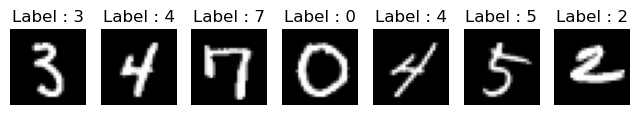

In [20]:
figure = plt.figure(figsize=(8, 8))
n_figs = 7

for i in range(n_figs):
    idx = np.random.randint(X_train.shape[0]) # take one image at random
    
    figure.add_subplot(1, n_figs, i + 1)
    img, label = X_train[idx], y_train[idx].item()

    plt.title("Label : " + str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")

# 3. Building the neural network architecture

We will implement the example used in the Pytorch tutorial which can be found [here](https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

**Defining the neural network class**

Neural networks comprise of layers/modules that perform operations on data.

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the forward method.

A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

Here, we build a neural network with three fully connected layers and ReLU nonlinearity.

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.layers(x)
        return output

We create an instance of `NeuralNetwork`, and move it to the device, and print its structure.

In [22]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [23]:
layer_weight_number = [p.numel() for p in model.parameters()]
print("Number of weights for each parameter : ", layer_weight_number)
print("Total number of weights in the model : ", sum(layer_weight_number))

Number of weights for each parameter :  [50176, 64, 2048, 32, 320, 10]
Total number of weights in the model :  52650


**Applying the model to an image**

Let us apply our model to the first image in our dataset to understand its output.

In [24]:
X0, y0 = X_train[0], y_train[0]

# this make the shape (1,28,28) instead of (28,28)
# indeed, the first dimension the model takes in the input is the batch dimension
X0 = X0.unsqueeze(0) 

output = model(X0.to(device))
print(output)

tensor([[-4.6365,  4.4897, -3.5467,  7.3695, 14.3279, -0.6486, -6.9893,  1.1564,
          8.1207,  3.3679]], grad_fn=<AddmmBackward0>)


The model returns a 10-dimensional vector which encodes the prediction score for each class. To turn this into prediction *probabilities*, we pass it through the softmax function, where

$$[softmax(u)]_i = \frac{e^{u_i}}{\sum_{j=0}^9 e^{u_j}}$$

In [27]:
predicted_probab = nn.Softmax(dim=1)(output)
print(predicted_probab)

tensor([[5.7879e-09, 5.3211e-05, 1.7211e-08, 9.4771e-04, 9.9697e-01, 3.1223e-07,
         5.5045e-10, 1.8983e-06, 2.0087e-03, 1.7331e-05]],
       grad_fn=<SoftmaxBackward0>)


This vector now represents the probability, according to the model, that the image belongs to each class. The predicted class corresponds to the index with the largest probability.

In [28]:
y0_pred = predicted_probab.argmax(1).item()
print("Predicted class:", y0_pred)
print("True class:", y0.item())

Predicted class: 4
True class: 5


We now proceed to train the model to predict the correct class. To this end, we first define the loss function. For multi-class classification problems, it is common to use the Cross Entropy Loss (a generalization of the logistic loss to multiple classes)

In [26]:
# defining the loss function
loss_fn = nn.CrossEntropyLoss()

# 4 .Training the neural network

We are now going to implement the stochastic gradient method using the Pytorch functionalities. 


### Computing gradient and updating weights

First, we need to understand how to compute gradients using auto-differentation

In [29]:
# example of a gradient computation : computing the gradient of the loss on
# one batch

X_batch, y_batch = X_train[:5], y_train[:5]

logits = model(X_batch.to(device))
loss = loss_fn(logits, y_batch.to(device)) # compute loss function on current batch

model.zero_grad()   # clear old gradients (important !)
loss.backward()     # compute gradients by backpropagation

print("The current loss on batch [0:5] is equal to ", loss.item())

# now the gradients for each layer weights are stored inside the model. 
for param in model.parameters():
    print(param.grad.shape)

The current loss on batch [0:5] is equal to  8.15256404876709
torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


The next function allows to perform a gradient step to update the model parameters.

In [30]:
@torch.no_grad()
def gradient_step(model, step_size):
    for param in model.parameters():
        param.add_( - step_size * param.grad ) # performing the addition in place

## Implementing SGD

It is now your turn ! Implement the stochastic gradient method using backpropagation, for a given batch size and step size sequence.

In [31]:
# parameters
def SGD(model, gamma, batch_size, N_iterations):
    N = len(MNIST_train)
    loss_fn = nn.CrossEntropyLoss()
    
    for it in range(N_iterations):
        # sample a random batch
        indices = torch.randperm(N)[:batch_size]
        X_batch = X_train[indices]
        y_batch = y_train[indices]
        
        # forward pass
        logits = model(X_batch.to(device))
        loss = loss_fn(logits, y_batch.to(device))
        
        # backward pass
        model.zero_grad()
        loss.backward()
        
        # gradient step
        gradient_step(model, gamma)

In [32]:
def train_loss(model, X, Y):
    loss_fn = nn.CrossEntropyLoss()
    logits = model(X.to(device))
    loss = loss_fn(logits, Y.to(device))
    return loss.item()

In [33]:
# do not forget to re-initialize model between runs : 
model = NeuralNetwork().to(device)

- Question 4.2

**Tuning the step size**

Try different values of fixed step size and compare the performance by plotting the train loss. 
Some tips : 
- you need to compute the train loss on the **full data**. Since this requires iterating over the full dataset, do not do this at each stochastic gradient step, but only once in a while 
- if one epoch takes too long, decrease the number of total iterations
- in SGD, the batch should be taken as a random subset of the data points. However, from a computational standpoint, it is much more efficient to pre-shuffle the data and take minibatches sequentially


Training with step size gamma = 0.001
  Iteration 1000: Train loss = 0.3037
  Iteration 2000: Train loss = 0.2154
  Iteration 3000: Train loss = 0.1751
  Iteration 4000: Train loss = 0.1679
  Iteration 5000: Train loss = 0.1382

Training with step size gamma = 0.01
  Iteration 1000: Train loss = 1.1828
  Iteration 2000: Train loss = 1.0368
  Iteration 3000: Train loss = 1.1721
  Iteration 4000: Train loss = 0.8832
  Iteration 5000: Train loss = 1.1730

Training with step size gamma = 0.05
  Iteration 1000: Train loss = 2.3019
  Iteration 2000: Train loss = 2.3013
  Iteration 3000: Train loss = 2.3014
  Iteration 4000: Train loss = 2.3014
  Iteration 5000: Train loss = 2.3013

Training with step size gamma = 0.1
  Iteration 1000: Train loss = 2.3015
  Iteration 2000: Train loss = 2.3017
  Iteration 3000: Train loss = 2.3018
  Iteration 4000: Train loss = 2.3016
  Iteration 5000: Train loss = 2.3018


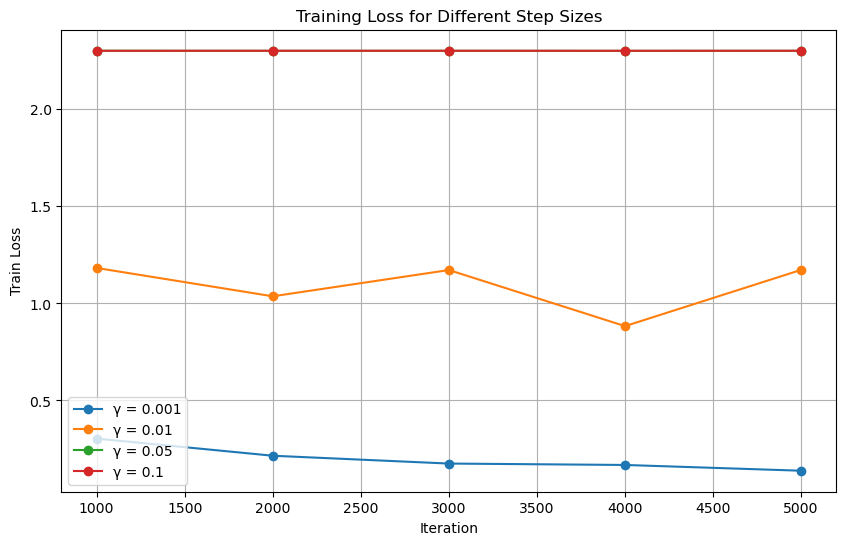


Training complete. Compare the curves to select the best step size.


In [ ]:
# Tuning the step size: try different values and compare
import matplotlib.pyplot as plt

# Define different step sizes to try
step_sizes = [0.001, 0.01, 0.05, 0.1]
batch_size = 32
N_iterations = 5000
eval_frequency = 1000  

results = {}

for gamma in step_sizes:
    print(f"\nTraining with step size gamma = {gamma}")
    
    model = NeuralNetwork().to(device)
    
    N = len(MNIST_train)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    iterations = []
    
    # Pre-shuffle the data
    indices = torch.randperm(N)
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    for it in range(N_iterations):
        batch_idx = (it * batch_size) % N
        if batch_idx + batch_size <= N:
            X_batch = X_shuffled[batch_idx:batch_idx + batch_size]
            y_batch = y_shuffled[batch_idx:batch_idx + batch_size]
        else:
            X_batch = X_shuffled[batch_idx:]
            y_batch = y_shuffled[batch_idx:]
        
        # Forward pass
        logits = model(X_batch.to(device))
        loss = loss_fn(logits, y_batch.to(device))
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Gradient step
        gradient_step(model, gamma)
        
        # Evaluate train loss periodically
        if (it + 1) % eval_frequency == 0:
            train_loss_val = train_loss(model, X_train, y_train)
            train_losses.append(train_loss_val)
            iterations.append(it + 1)
            print(f"  Iteration {it + 1}: Train loss = {train_loss_val:.4f}")
    
    results[gamma] = (iterations, train_losses)


plt.figure(figsize=(10, 6))
for gamma, (iters, losses) in results.items():
    plt.plot(iters, losses, marker='o', label=f'γ = {gamma}')

plt.xlabel('Iteration')
plt.ylabel('Train Loss')
plt.title('Training Loss for Different Step Sizes')
plt.legend()
plt.grid(True)
plt.show()

print("\nTraining complete. Compare the curves to select the best step size.")

### Computing the model accuracy

To evaluate the performance of your model, you need to compute its accuracy on the test data.

In [36]:
# computing the accuracy
def accuracy(model, X, Y):
    logits = model(X.to(device))
    predictions = logits.argmax(dim=1)
    correct = (predictions == Y.to(device)).sum().item()
    total = Y.shape[0]
    return correct / total

Examine  how the accuracy evolves during the training.

Starting training for 5 epochs...
Step size (gamma) = 0.01, Batch size = 32

Epoch 1/5
  Train Accuracy: 0.4966, Test Accuracy: 0.5012

Epoch 2/5
  Train Accuracy: 0.5331, Test Accuracy: 0.5345

Epoch 3/5
  Train Accuracy: 0.5656, Test Accuracy: 0.5760

Epoch 4/5
  Train Accuracy: 0.6052, Test Accuracy: 0.6016

Epoch 5/5
  Train Accuracy: 0.6529, Test Accuracy: 0.6539



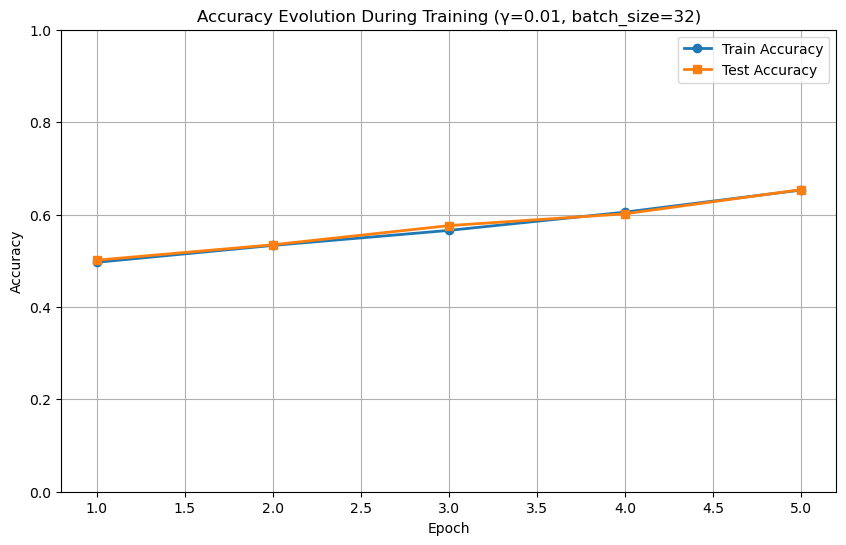


OBSERVATIONS AND ANALYSIS:

Train Accuracy progression: ['0.4966', '0.5331', '0.5656', '0.6052', '0.6529']
Test Accuracy progression:  ['0.5012', '0.5345', '0.5760', '0.6016', '0.6539']

Final Train Accuracy: 0.6529
Final Test Accuracy:  0.6539

Accuracy improvement: 0.1527
Max gap between train and test accuracy: 0.0036

WHEN TO STOP TRAINING?

1. **Early Stopping Criterion**: Monitor the test accuracy (generalization performance).
   Stop when test accuracy starts to plateau or decrease (overfitting).

2. **Observations from our training:**
   - If test accuracy increases throughout: Continue training
   - If test accuracy plateaus: Further training may not help
   - If test accuracy decreases while train accuracy increases: Overfitting detected

3. **Best Practice**:
   - Use a validation set (different from test set)
   - Track both train and test accuracy
   - Stop if test accuracy hasn't improved for N consecutive epochs
   - Save the model weights at the best validation accurac

In [37]:


model = NeuralNetwork().to(device)

# Parameters
gamma = 0.01          
batch_size = 32
n_epochs = 5
N = len(MNIST_train)
loss_fn = nn.CrossEntropyLoss()

# Track metrics
train_accuracies = []
test_accuracies = []
epoch_numbers = []

print("Starting training for 5 epochs...")
print(f"Step size (gamma) = {gamma}, Batch size = {batch_size}\n")

# Pre-shuffle the data
indices = torch.randperm(N)
X_shuffled = X_train[indices]
y_shuffled = y_train[indices]

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    
    # Training pass
    for it in range(N // batch_size):
        batch_idx = it * batch_size
        X_batch = X_shuffled[batch_idx:batch_idx + batch_size]
        y_batch = y_shuffled[batch_idx:batch_idx + batch_size]
        
        # Forward pass
        logits = model(X_batch.to(device))
        loss = loss_fn(logits, y_batch.to(device))
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Gradient step
        gradient_step(model, gamma)
    
    # Evaluate accuracy at the end of each epoch
    train_acc = accuracy(model, X_train, y_train)
    test_acc = accuracy(model, X_test, y_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    epoch_numbers.append(epoch + 1)
    
    print(f"  Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}\n")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, train_accuracies, marker='o', label='Train Accuracy', linewidth=2)
plt.plot(epoch_numbers, test_accuracies, marker='s', label='Test Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Evolution During Training (γ={gamma}, batch_size={batch_size})')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])
plt.show()

# Analysis
print("\n" + "="*60)
print("OBSERVATIONS AND ANALYSIS:")
print("="*60)
print(f"\nTrain Accuracy progression: {[f'{acc:.4f}' for acc in train_accuracies]}")
print(f"Test Accuracy progression:  {[f'{acc:.4f}' for acc in test_accuracies]}")
print(f"\nFinal Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy:  {test_accuracies[-1]:.4f}")
print(f"\nAccuracy improvement: {test_accuracies[-1] - test_accuracies[0]:.4f}")

# Check for overfitting
max_gap = max(train_accuracies[i] - test_accuracies[i] for i in range(len(train_accuracies)))
print(f"Max gap between train and test accuracy: {max_gap:.4f}")

print("\n" + "="*60)
print("WHEN TO STOP TRAINING?")
print("="*60)
print("""
1. **Early Stopping Criterion**: Monitor the test accuracy (generalization performance).
   Stop when test accuracy starts to plateau or decrease (overfitting).
   
2. **Observations from our training:**
   - If test accuracy increases throughout: Continue training
   - If test accuracy plateaus: Further training may not help
   - If test accuracy decreases while train accuracy increases: Overfitting detected
   
3. **Best Practice**:
   - Use a validation set (different from test set)
   - Track both train and test accuracy
   - Stop if test accuracy hasn't improved for N consecutive epochs
   - Save the model weights at the best validation accuracy
""")

## Some concluding remarks

In this TP, you implemented things at a relatively low level so that you understand the mechanics.
In practice, there are some convenient modules that you can use in Pytorch :

- `torch.utils.data.DataLoader` implements the `DataLoader` class to facilitate handling data. It allows to easily preprocess, shuffle and iterate the data.
- `torch.optim` implements ready-to-use optimization algorithms, such as stochastic gradient descent, momentum, Adagrad, Adam...
